# Supply Chain Forecasting using Network Autoregressive Models
## The NAR Model

Let $G = (V, E)$ be a graph with $|G| = N$ nodes such that for every node $i$ we observe a property $X_i^{(t)} \in \mathbb{R}$ and  $p$ covariates stacked into $Y_i^{(t)} \in \mathbb{R}^p$ for times $t=1, ..., T$ where $T$ is a fixed bound. Then, the network autoregressive model (NAR) models the response variable $X_i^{(t)}$ with a combination of its past values or lags, past values of relevant nodes, and the observed covariates. That is,

$$ X_i^{(t)} = \sum_{j=1}^{d_1} a_i^{(j)} X_i^{(t-j)} + \sum_{j=1}^{d_2} b_i^{(j)} \sum_{k=1}^{N} w_{i, k} X_k^{(t-j)} + c_{i}^T Y_i^{(t-1)} + \epsilon_i^{(t)},$$ 
where $\epsilon_i^{(t)}$ is the error term with expected value $0$, and $d_1$, $d_2$ are referred to as the self lags and network lags respectively. Sometimes we refer to this model by NAR($d_1, d_2$). 
For simplicity, we will assume $w_{i,k} = 1$ if there is an edge between nodes $i$ and $k$, and $0$ otherwise.

This approach is more complex than modelling each individual time series independently of each other, however the benefit is that the relationship across different time series is preserved. This is similar to the vector autoregressive model (VAR), but the network structure allows for parameter reduction which makes it more efficient. 

Let $\mathbb{X}_t, \mathbb{\epsilon}_t \in \mathbb{R}^N$ be vectors stacking every $X_i^{(t)}$ and $\epsilon_i^{(t)}$ respectively, 
$\mathbb{Y}_{k, t-1} =  \begin{bmatrix} Y_{1k, t-1} & ... & Y_{Nk, t-1} \end{bmatrix} \in \mathbb{R}^N$ for $k = 1, ..., p,$ 
and 
$W_{ik} = w_{i, k}$ for $i, k = 1, ..., N$. Define $d=\max\{d_1, d_2\}$, 
$$ \begin{array}{c}
\mathbb{Z}_{t-1}  = \begin{bmatrix}
Z_{t-1} & ... & Z_{t-d} & \text{diag}\{\mathbb{Y}_{1, \, t-1}\} & ... & \text{diag}\{\mathbb{Y}_{p, \, t-1}\} 
\end{bmatrix}, 
\\ \\
Z_{t-l}  = \begin{bmatrix}
\text{diag}\{\mathbb{X}_{t-l}\} & \text{diag}\{W\mathbb{X}_{t-l}\} 
\end{bmatrix} \text{ for $l = 1, ..., d$}, 
\\ \\ 
\beta  = \begin{bmatrix}
\beta_1^T & ... & \beta_d^T & \gamma_1^T & ... & \gamma_p^T
\end{bmatrix}^T,
\\ \\
\beta_l  = \begin{bmatrix}
a_1^{(l)} & ... & a_N^{(l)} & b_1^{(l)} & ... & b_N^{(l)} 
\end{bmatrix}^T \text{ for $l = 1, ..., d$},
\\ \\
\gamma_k  = \begin{bmatrix}
c_{1,k} & ... & c_{N,k} \end{bmatrix}^T \text{ for $k = 1, ..., p$}.
\end{array}$$ 
Then we can express our NAR model in a simpler recursive form,
$$\mathbb{X}_t = \mathbb{Z}_{t-1} \beta + \epsilon_t,$$ from which we want to calculate the regression coefficients $\beta$. We can use the ordinary least squares (OLS) estimator, obtained as

$$\hat{\beta}_{\text{OLS}} = \left ( \sum_{t=1}^T \mathbb{Z}_{t-1}^T \mathbb{Z}_{t-1} \right) ^{-1} \sum_{t=1}^T \mathbb{Z}_{t-1}^T \mathbb{X}_{t}.$$

In [54]:
import numpy as np
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

"""
Parameters to the methods:
X: An (N, T) array containing the observed property values for N nodes over T time periods.
Y: An (N, T, p) array containing p covariates for each of the N nodes over T time periods.
W: An (N, N) adjacency matrix representing the network structure.
d_1: The number of self lags.
d_2: The number of network lags.
t: The current time step.
"""   

def compute_Z_t_minus_1(X, Y, W, d_1, d_2, t):
    #Returns the matrix Z_{t-1} used in the NAR model for time step t
    #Whenever t is given as a parameter to a method, it is the real time
    #Whenever we use time as an index for a matrix, t-1 should be used. 
    #Same with the node index
    #We start from t=1 and N=1
    N, T = X.shape[0], X.shape[1]
    p = Y.shape[2] # N, T, p
    d = max(d_1, d_2)

    #Compute Z_t_minus_l for l = 1, ..., d
    Z_t_minus_l = []
    for l in range(1, d+1):
        if t-l-1 < 0:
            Z_t_minus_l.append(np.zeros((N, 2*N)))
        else:    
            Z_t_minus_l.append(np.hstack((np.diag(X[:, t-l-1]), np.diag(np.dot(W, X[:, t-l-1])))))

    for k in range(0, p):
        if k < 0:
            print('Negative k:', k)
        Z_t_minus_l.append(np.diag(Y[:, t-1-1, k]))
    return np.hstack(Z_t_minus_l)

def compute_beta_OLS(X, Y, W, d_1, d_2):
    #Returns the beta OLS estimate of the regression coefficients.
    N, T = X.shape[0], X.shape[1]
    p = Y.shape[2] # N, T, p
    d = max(d_1, d_2)
    firstSum = np.zeros((2*N*d+N*p, 2*N*d+N*p))
    secondSum = np.zeros((2*N*d+N*p, 1))

    for t in range(1, T+1):
        Z = compute_Z_t_minus_1(X, Y, W, d_1, d_2, t)
        firstSum += np.transpose(Z) @ Z
        secondSum += np.transpose(Z) @ ((X[:, t-1])[:, np.newaxis]) #X_t = (X[:, t-1])
                
    beta = np.linalg.pinv(firstSum) @ secondSum
    return beta

def compute_response_X_t(X, Y, W, d_1, d_2, t, beta):
    #Returns the predicted values of the response variable at time step t.
    return compute_Z_t_minus_1(X, Y, W, d_1, d_2, t) @ beta

In [55]:
def get_a_b_c(N, T, p, d, beta):
    #Given the combined coefficient vector beta, returns coefficient vectors a, b and c
    a = np.zeros((N, d))
    b = np.zeros((N, d))
    c = np.zeros((N, p))    
    for i in range(d):
        a[:, i] = beta[2*N*i : 2*N*i + N].reshape(-1)         
        b[:, i] = beta[2*N*i + N : 2*N*i + 2*N].reshape(-1)        
    for i in range(p):
        c[:, i] = beta[2*N*d + i*N : 2*N*d + i*N + N].reshape(-1)        
    return a, b, c

def compute_response_X_t_using_loop(X, Y, W, d_1, d_2, t, beta, i):
    #Computes the response at time t using the explicit NAR formula
    N, T = X.shape[0], X.shape[1]
    p = Y.shape[2]
    d = max(d_1, d_2)    
    a, b, c = get_a_b_c(N, T, p, d, beta)
    sum1 = 0
    sum2 = 0
    for j in range(1, d+1):
        sum1+= a[i-1][j-1]*X[i-1][t-j-1]
    
    for j in range(1, d+1):
        inner_sum = 0
        for k in range(1, N+1):
            inner_sum += W[i-1][k-1]*X[k-1][t-j-1]
        sum2 += b[i-1][j-1] * inner_sum
    
    covariate_term = c[i-1] @ Y[i-1][t-1-1]
    
    return sum1 + sum2 + covariate_term

## Experiments using Simulated Data
### Stochastic Block Model

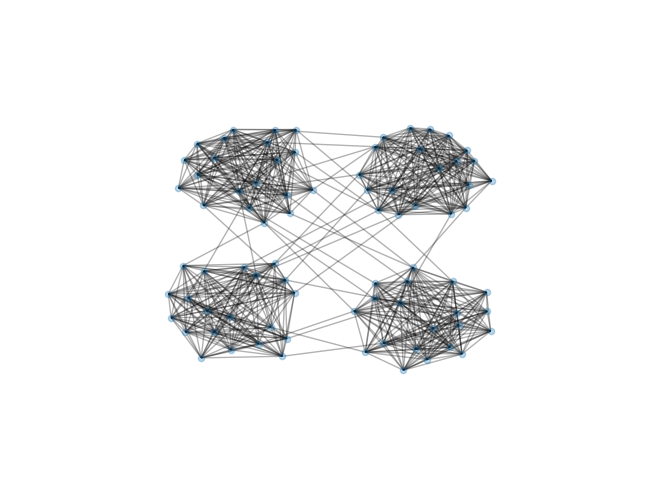

In [80]:
d = 10
N, T, p, d_1, d_2 = 80, 30, 5, d, d
sizes = [int(N/4)] * 4
probs = [
    [0.95, 0.015, 0.02, 0.015],
    [0.015, 0.95, 0.015, 0.02],
    [0.02, 0.015, 0.95, 0.015],
    [0.015, 0.02, 0.015, 0.95]
]
G = nx.stochastic_block_model(sizes, probs, seed=150)
nx.draw_kamada_kawai(G, node_size = 20, alpha=0.3,margins=0.4)
W = nx.to_numpy_array(G)
Y = np.random.randint(-2, 2, (N, T, p))
beta = np.random.rand(2*N*d+N*p,)

In [81]:
#Calculate response X on all nodes up to time T with NAR and the generated beta
X_first_d_terms = np.random.randint(10, size=(N, d))
X = np.zeros((N,T))
X[0:N , 0:d] = X_first_d_terms

for t in range(d+1, T+1): 
    for i in range(1, N+1): #add noise with np.random.rand()
        X[i-1][t-1] = compute_response_X_t_using_loop(X, Y, W, d_1, d_2, t, beta, i) + np.random.rand()
        
predicted_beta = compute_beta_OLS(X, Y, W, d_1, d_2)

#MSE and MAE of the predicted beta
print('MSE of predicted beta:', mean_squared_error(predicted_beta, beta))
print('MAE of predicted beta:', mean_absolute_error(predicted_beta, beta))

MSE of predicted beta: 0.29721589559100486
MAE of predicted beta: 0.4574663346066869


In [82]:
print(beta[100:110])
print(np.transpose((predicted_beta[100:110]))[0])

[0.77557242 0.04236632 0.45237213 0.40961546 0.70346926 0.70660492
 0.20777519 0.98882869 0.42858682 0.43859195]
[0.7686344  0.03175768 0.45172366 0.40181896 0.69463938 0.7001019
 0.19948254 0.97806169 0.41987092 0.42738436]


## The Supply Graph Dataset

We will focus on the SupplyGraph dataset, which is a real-world benchmark dataset obtained from a prominent Fast Moving Consumer Goods company in Bangladesh and retrieved from https://github.com/CIOL-SUST/SupplyGraph. The dataset covers the period from January 1, 2023, to August 9, 2023, and includes features such as production, sales orders, delivery to distributors, and factory issues.

In terms of dataset statistics, SupplyGraph comprises a total of 41 products as nodes, categorized into 5 distinct groups and 19 sub-groups. Additionally, the dataset includes 25 plants and 13 storage locations represented as nodes in the graph. The edges in the dataset encompass a total of 62 edge types, with 684 unique edges connecting the nodes. These edges define the relationships between different components of the supply chain, such as shared product groups, sub-groups, plants, and storage locations. For more information about the data, you may check [2].

### Building the adjacency matrix $W$
We set $W_{ij} = 1$ if products $i$ and $j$ are in the same distribution plant and $0$ otherwise.

In [83]:
#Create a list of nodes
nodes_df = pd.read_csv('nodes.csv')
nodes = nodes_df['Node'].tolist()

N = len(nodes)
print('Number of nodes =', N)

def build_W(edges_file):
    #Read the edges.csv file
    edges_df = pd.read_csv(edges_file)

    #Initialize the adjacency matrix W
    W = np.zeros((N, N))

    #Fill the adjacency matrix W based on the edges information
    for index, row in edges_df.iterrows():
        node1_index = nodes.index(row['node1'])       
        node2_index = nodes.index(row['node2'])
        W[node1_index, node2_index] = 1
        W[node2_index, node1_index] = 1
    return W

W = build_W('edges_plant.csv')

Number of nodes = 41


We visualize the graph made with edges_plant.csv below.

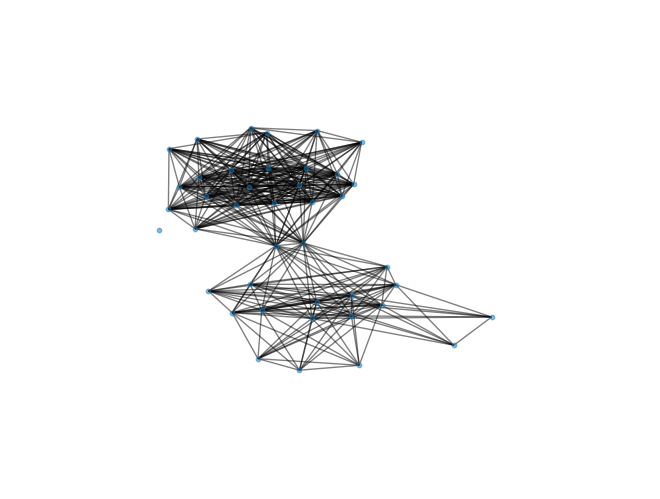

In [84]:
G=nx.from_numpy_array(W)
nx.draw_kamada_kawai(G, node_size=10, with_labels=False, alpha=0.5, margins = 0.4)

### Building the response variable matrix $X$ and covariate matrix $Y$

In [85]:
T=100
#Read the SalesOrder.csv file
sales_df = pd.read_csv('SalesOrder.csv')
#Select the first 30 rows, excluding the 'Date' column
selected_data = sales_df.iloc[:T, 1:].values
X_data_T = np.array(selected_data)
X_data = np.transpose(X_data_T)

#3 covariate files to be preprocessed
p = 3
factory_df = pd.read_csv('FactoryIssue.csv')
factory_df = factory_df.iloc[:T, 1:].values

production_df = pd.read_csv('Production.csv')
production_df = production_df.iloc[:T, 1:].values

delivery_df = pd.read_csv('DeliveryToDistributor.csv')
delivery_df = delivery_df.iloc[:T, 1:].values

#Y has shape N, T, p
Y_data = np.zeros((N, T, p))
for i in range(0, N):
    for j in range (0, T):
        #Obtain from FactoryIssue.csv
        Y_data[i][j][0] = factory_df[j][i]
        #Obtain from Production.csv    
        Y_data[i][j][1] = production_df[j][i]
        #Obtain from DeliveryToDistributor.csv    
        Y_data[i][j][2] = delivery_df[j][i]

## Testing our model

We predict the next row in sales_df corresponding to the 101st one.

Average true sales order value at time 100 = 1088.082317043714
MAE of graph with plant edges = 384.5131455950094
MSE of graph with plant edges = 768173.1378282837
-


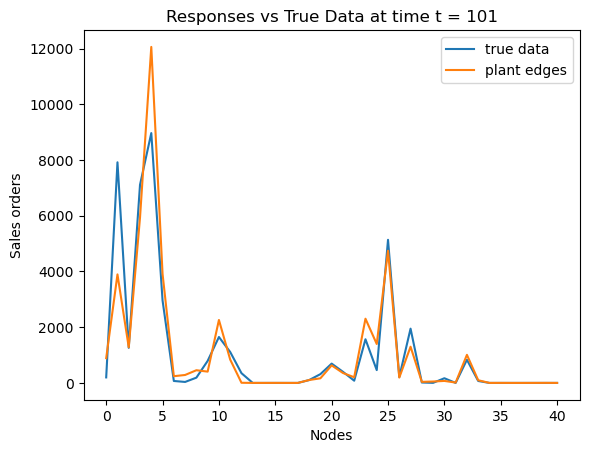

In [86]:
time = T
d_1 = 10
d_2 = 10
#Sales orders on the next day, row T, corresponding to time T+1
true_data = sales_df.iloc[time, 1:].values

#Compute beta_OLS
predicted_beta = compute_beta_OLS(X_data, Y_data, W, d_1, d_2)
#Compute response
response = compute_response_X_t(X_data, Y_data, W, d_1, d_2, time+1, predicted_beta) #computed at time T+1

print('Average true sales order value at time', T, '=', sum(true_data)/len(true_data))
def testing(response, true_data, name, show_true_data=False):
    response_ = np.transpose(response)[0]
    mse = mean_squared_error(response_, true_data)
    mae = mean_absolute_error(response_, true_data)
    
    print('MAE of graph with ' + name + ' = ' + str(mae))
    print('MSE of graph with ' + name + ' = ' + str(mse))
    print('-')

    #plot response vs true data
    x = list(range(0, 41))   
    if show_true_data:
        plt.plot(x, true_data, label='true data')
    plt.plot(x, np.transpose(response)[0], label=name)
    
testing(response, true_data, 'plant edges', show_true_data=True)
#display the legend and show the plot
plt.legend()
plt.xlabel('Nodes')
plt.ylabel('Sales orders')
plt.title('Responses vs True Data at time t = '+str(time+1))
plt.show()

### Testing with other graphs
In [2] there are 3 more suggested ways of creating the graphs, that we test here, as well as a random graph and a graph with no edges.

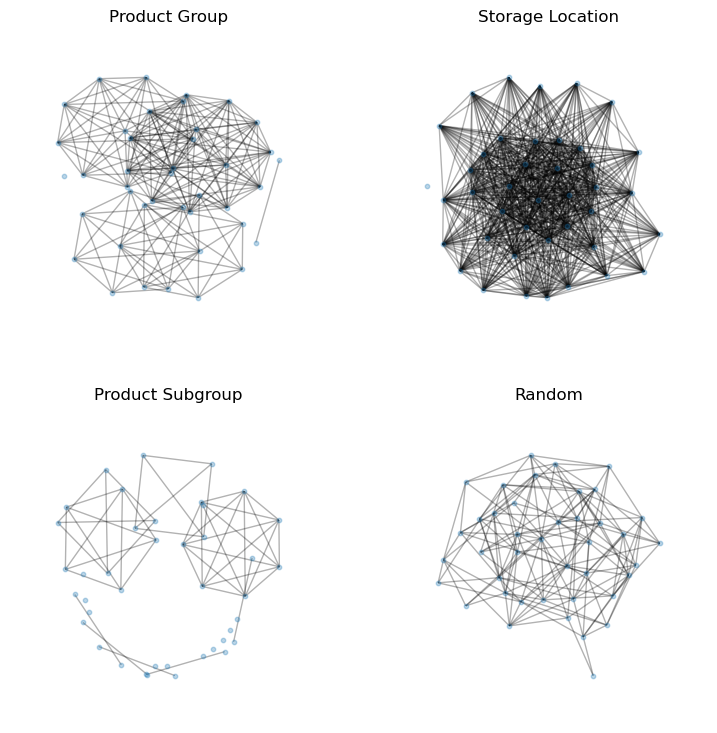

In [87]:
W_1 = build_W('edges_product_group.csv')
G_1=nx.from_numpy_array(W_1)

W_2 = build_W('edges_storage_location.csv')
G_2=nx.from_numpy_array(W_2)

W_3 = build_W('edges_product_subgroup.csv')
G_3=nx.from_numpy_array(W_3)

#Graph with random edges
W_4 = np.random.choice([0, 1], (N,N), p=[0.9, 0.1])
W_4[range(N), range(N)] = 0
G_4=nx.from_numpy_array(W_4)

#Graph with no edges
W_5 = np.zeros((N, N))
G_5 = nx.from_numpy_array(W_5)

graphs = [G_1, G_2, G_3, G_4]
titles = ['Product Group', 'Storage Location', 'Product Subgroup', 'Random']
#Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
axs = axs.flatten()
#Plot each graph in a subplot
for i, graph in enumerate(graphs):
    nx.draw_kamada_kawai(graph, ax=axs[i], node_size=10,with_labels=False, alpha=0.3, margins=0.15)
    axs[i].set_title(titles[i])
#plt.tight_layout()
plt.show()

Average true sales order value at time 100 = 1088.082317043714
MAE of graph with product group edges = 403.827077892443
MSE of graph with product group edges = 652347.7718210263
-
MAE of graph with storage location edges = 307.54709402986373
MSE of graph with storage location edges = 351512.3683409113
-
MAE of graph with product subgroup edges = 464.76549737111065
MSE of graph with product subgroup edges = 1016769.7469394411
-
MAE of graph with random edges = 350.20827073512675
MSE of graph with random edges = 559303.0054748955
-
MAE of graph with no edges = 357.1354466158148
MSE of graph with no edges = 769483.4683376038
-


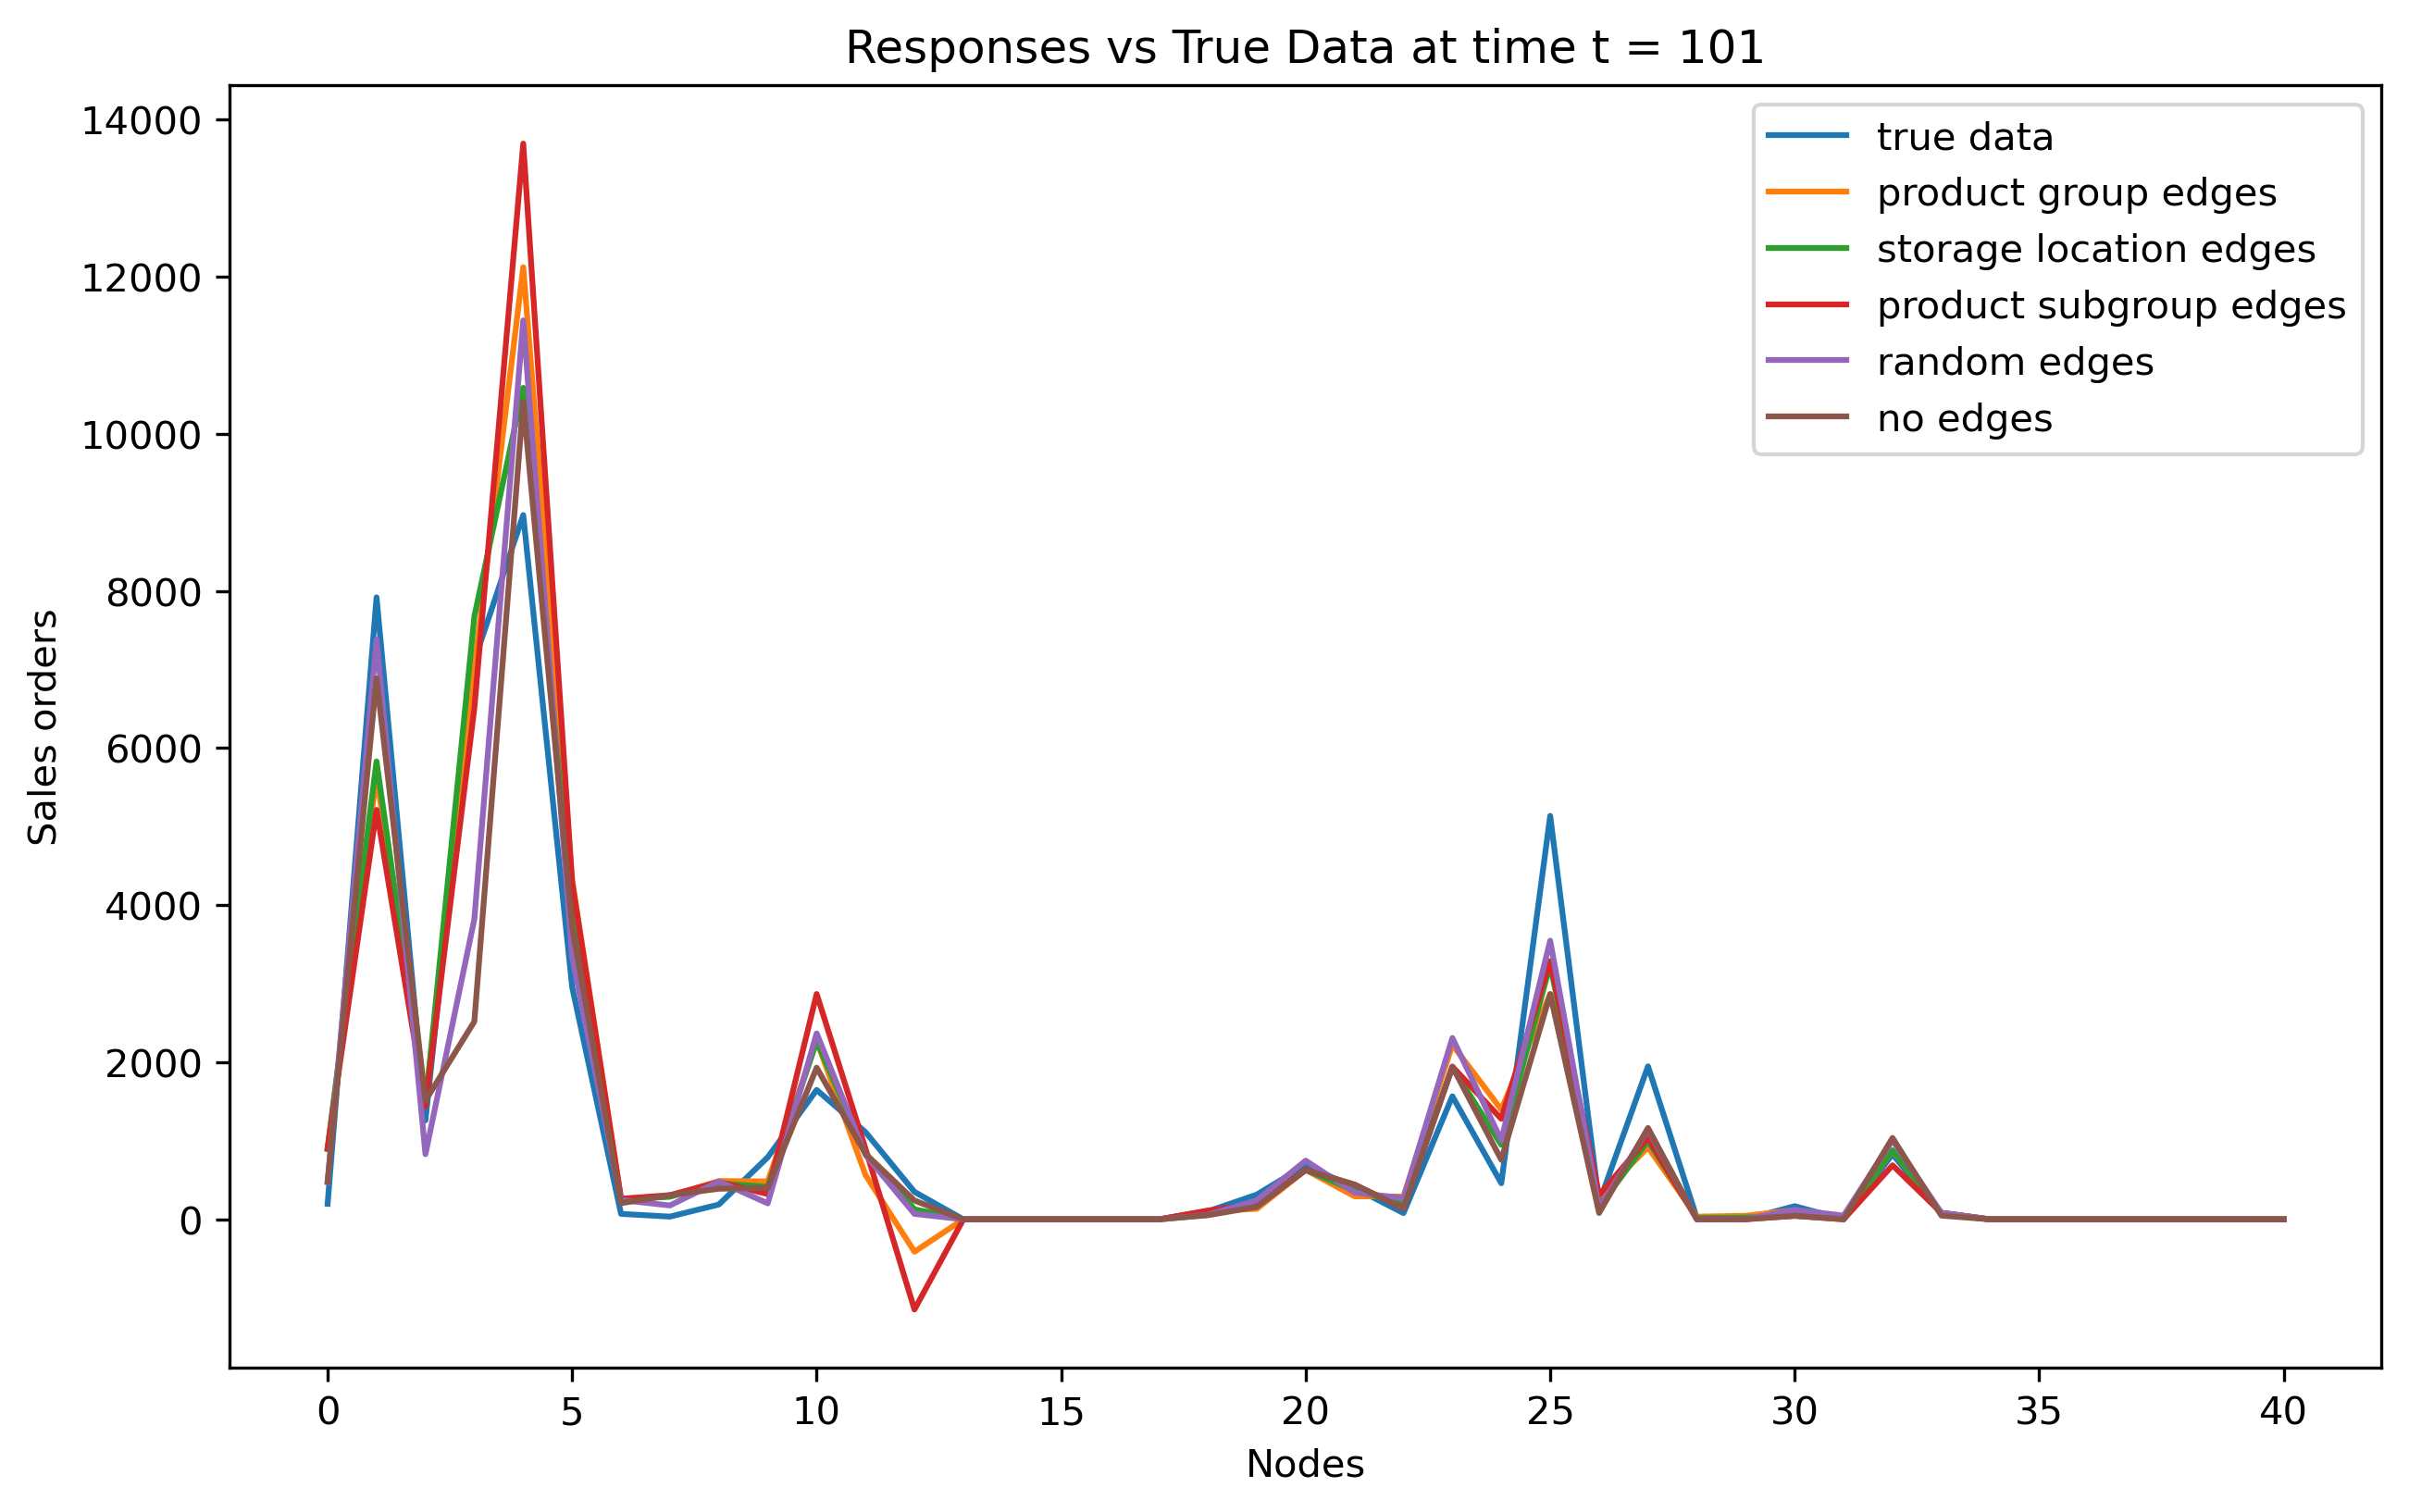

In [88]:
predicted_beta_1 = compute_beta_OLS(X_data, Y_data, W_1, d_1, d_2)
predicted_beta_2 = compute_beta_OLS(X_data, Y_data, W_2, d_1, d_2)
predicted_beta_3 = compute_beta_OLS(X_data, Y_data, W_3, d_1, d_2)
predicted_beta_4 = compute_beta_OLS(X_data, Y_data, W_4, d_1, d_2)
predicted_beta_5 = compute_beta_OLS(X_data, Y_data, W_5, d_1, d_2)

response_1 = compute_response_X_t(X_data, Y_data, W_1, d_1, d_2, time+1, predicted_beta_1)
response_2 = compute_response_X_t(X_data, Y_data, W_2, d_1, d_2, time+1, predicted_beta_2)
response_3 = compute_response_X_t(X_data, Y_data, W_3, d_1, d_2, time+1, predicted_beta_3)
response_4 = compute_response_X_t(X_data, Y_data, W_4, d_1, d_2, time+1, predicted_beta_4)
response_5 = compute_response_X_t(X_data, Y_data, W_5, d_1, d_2, time+1, predicted_beta_5)

print('Average true sales order value at time', T, '=', sum(true_data)/len(true_data))
#Initialize the plot
plt.figure(figsize=(10, 6), dpi=300)

testing(response_1, true_data, 'product group edges', show_true_data=True)
testing(response_2, true_data, 'storage location edges')
testing(response_3, true_data, 'product subgroup edges')
testing(response_4, true_data, 'random edges')
testing(response_5, true_data, 'no edges')
#Display the legend and show the plot
plt.legend()
plt.xlabel('Nodes')
plt.ylabel('Sales orders')
plt.title('Responses vs True Data at time t = '+str(time+1))
plt.show()

The performance seems to be consistent independent of the graph structure, this could be studied further.

# Bibliography

[1] Kozodoi, N., Zinovyeva, E., Valentin, S., Pereira, J., $\&$ Agundez, R. (2024). Probabilistic demand forecasting with graph neural networks. arXiv preprint arXiv:2401.13096.

[2] Toushik Wasi, A., Islam, S., $\&$ Raihan Akib, A. (2024). SupplyGraph: A Benchmark Dataset for Supply Chain Planning using Graph Neural Networks. arXiv e-prints, arXiv-2401.

[3] Yin, H., Safikhani, A., $\&$ Michailidis, G. (2023). A general modeling framework for network autoregressive processes. Technometrics, 65(4), 579-589.

[4] Zhu, X., Pan, R., Li, G., Liu, Y., $\&$ Wang, H. (2017). Network vector autoregression.